In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import f_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import openml


In [2]:
dataset=openml.datasets.get_dataset(1477)
x, y, _, _ = dataset.get_data(dataset_format='dataframe', target=dataset.default_target_attribute)

In [3]:
def drop_redundant_featuers(x, threshold=0.9, method='pearson'):
    corr_matrix=x.corr(method=method)
    upper_triangular_matrix=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
    dropped_features = [
        col for col in upper_triangular_matrix.columns
        if any(upper_triangular_matrix[col] > threshold)
    ]
    x_red = x.drop(columns=dropped_features)

    return x_red


In [4]:
x_new = drop_redundant_featuers(x, 0.9, 'pearson')
x_new.shape

(13910, 32)

In [5]:
x_new = drop_redundant_featuers(x, 0.9, 'spearman')
x_new.shape

(13910, 16)

In [6]:
anova_score,_=f_classif(x_new,y)
anova_df=pd.DataFrame({
    'Feature':x_new.columns,
    'ANOVA Score': anova_score,
}).sort_values(by='ANOVA Score',ascending=False)
anova_df

,Feature,ANOVA Score
3,V9,3415.946684
4,V14,2187.692262
0,V1,1878.967258
2,V6,1273.940627
5,V17,918.223573
15,V129,831.354021
7,V22,759.989439
6,V18,727.691733
9,V33,567.416439
12,V38,332.876071


In [7]:
def anova_score_remove_features(x,y, threshold=5):
    anova_score,_=f_classif(x,y)
    anova_df=pd.DataFrame({
        'Feature':x.columns,
        'ANOVA Score': anova_score,
    }).sort_values(by='ANOVA Score',ascending=False)
    selected_features=anova_df[anova_df['ANOVA Score']>threshold]['Feature'].values
    x_anova=x[selected_features]
    return x_anova

In [8]:
x_anova = anova_score_remove_features(x_new, y, threshold=5)
print(x_anova)

               V9       V14          V1         V6         V17   V129  \
0      11800.9233 -1.388754  12285.6582  -1.312657   1376.0439   10.0   
1        266.4145 -0.135535    -35.6889  -0.130298   1175.7173   50.0   
2      57405.8483 -9.756099  63927.2217 -10.433776  12304.2205  250.0   
3       4301.4033 -0.916502   2992.9019  -0.755903   7940.1109  600.0   
4      50051.0703 -8.093597  57524.7812  -9.084750   8955.9827  150.0   
...           ...       ...         ...        ...         ...    ...   
13905  19013.4575 -3.304600  13384.8262  -2.142994   4803.2432   10.0   
13906  19034.2495 -3.282291  13382.9619  -2.156512   4791.4526   10.0   
13907  18997.7222 -3.294125  13336.8725  -2.146688   4814.2168   10.0   
13908  19035.9926 -3.293225  13351.1318  -2.143651   4840.9292   10.0   
13909  18973.1426 -3.282043  13314.9336  -2.138961   4696.2705   10.0   

            V22       V18        V33       V38         V2        V24  \
0     -0.238784  1.617861   627.1431 -0.125025   4.

In [9]:
standard_scaler=StandardScaler()
x_anove_scaled=standard_scaler.fit_transform(x_anova)
x = standard_scaler.fit_transform(x)

In [10]:
def chi2_score_remove_features(x, y, threshold=10):
    chi2_score,_=chi2(x,y)
    selected_chi2 = chi2_score >= threshold
    x_chi2 = x.iloc[:, selected_chi2]
    print("Shape after Chi2 feature selection:", x_chi2.shape)
    return x_chi2

In [11]:
x_chi2 = chi2_score_remove_features(abs(x_anova), y, threshold=10)
chi2_score,_=chi2(x_chi2,y)
chi2_df=pd.DataFrame({
    'Feature':x_chi2.columns,
    'Chi2 Score': chi2_score,
}).sort_values(by='Chi2 Score',ascending=False)
chi2_df

Shape after Chi2 feature selection: (13910, 16)


,Feature,Chi2 Score
0,V9,5.483876e+08
2,V1,5.423218e+08
4,V17,2.778769e+07
8,V33,3.486996e+06
5,V129,5.989612e+05
3,V6,7.731307e+04
1,V14,7.266423e+04
10,V2,3.337466e+04
11,V24,1.224215e+04
7,V18,9.724438e+03


In [12]:
knn=KNeighborsClassifier()
x_train, x_test,y_train,y_test=train_test_split(x_anova,y,test_size=0.2,random_state=42)
knn.fit(x_train,y_train)
y_pred=knn.predict(x_test)
accuracy=accuracy_score(y_test,y_pred)
print("KNN Classifier Accuracy:", accuracy)

KNN Classifier Accuracy: 0.9317038102084831


In [13]:
clf = RandomForestClassifier()
x_train, x_test,y_train,y_test=train_test_split(x_anova,y,test_size=0.2,random_state=42)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
accuracy=accuracy_score(y_test,y_pred)
print("Random Forest Classifier Accuracy:", accuracy)

Random Forest Classifier Accuracy: 0.9935298346513299


In [14]:
rfe = RFE(estimator=clf, n_features_to_select=13)

In [15]:
rfe.fit(x_train,y_train)
selected_features = x_train.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['V9', 'V14', 'V1', 'V6', 'V17', 'V129', 'V22', 'V18', 'V33', 'V38',
       'V2', 'V37', 'V34'],
      dtype='object')


In [16]:
lg_model = LogisticRegression(max_iter=1000)
rfe_lg = RFE(estimator=lg_model, n_features_to_select=13)
rfe_lg.fit(x_train, y_train)


/home/maxmaster/data/ITI/workspace/ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maxmaster/data/ITI/workspace/ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://s

,"estimator estimator: ``Estimator`` instanceA supervised learning estimator with a ``fit`` method that providesinformation about feature importance(e.g. `coef_`, `feature_importances_`).",LogisticRegre...max_iter=1000)
,"n_features_to_select n_features_to_select: int or float, default=NoneThe number of features to select. If `None`, half of the features areselected. If integer, the parameter is the absolute number of featuresto select. If float between 0 and 1, it is the fraction of features toselect... versionchanged:: 0.24 Added float values for fractions.",13
,"step step: int or float, default=1If greater than or equal to 1, then ``step`` corresponds to the(integer) number of features to remove at each iteration.If within (0.0, 1.0), then ``step`` corresponds to the percentage(rounded down) of features to remove at each iteration.",1
,"verbose verbose: int, default=0Controls verbosity of output.",0
,"importance_getter importance_getter: str or callable, default='auto'If 'auto', uses the feature importance either through a `coef_`or `feature_importances_` attributes of estimator.Also accepts a string that specifies an attribute name/pathfor extracting feature importance (implemented with `attrgetter`).For example, give `regressor_.coef_` in case of:class:`~sklearn.compose.TransformedTargetRegressor` or`named_steps.clf.feature_importances_` in case ofclass:`~sklearn.pipeline.Pipeline` with its last step named `clf`.If `callable`, overrides the default feature importance getter.The callable is passed with the fitted estimator and it shouldreturn importance for each feature... versionadded:: 0.24",'auto'
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True


In [17]:
selected_features_lg = x_train.columns[rfe_lg.support_]
print("Selected Features using Logistic Regression:", selected_features_lg)
y_pred_lg = rfe_lg.predict(x_test)
accuracy_lg = accuracy_score(y_test, y_pred_lg)
print("Logistic Regression Accuracy after RFE:", accuracy_lg)

Selected Features using Logistic Regression: Index(['V14', 'V6', 'V17', 'V129', 'V22', 'V18', 'V33', 'V2', 'V24', 'V37',
       'V104', 'V34', 'V40'],
      dtype='object')
Logistic Regression Accuracy after RFE: 0.6725377426312006


In [18]:
x_train_rfe = rfe.transform(x_train)
x_test_rfe = rfe.transform(x_test)

In [19]:
clf.fit(x_train_rfe,y_train)
y_pred_rfe=clf.predict(x_test_rfe)
accuracy_rfe=accuracy_score(y_test,y_pred_rfe)
print("Random Forest Classifier Accuracy after RFE:", accuracy_rfe)

Random Forest Classifier Accuracy after RFE: 0.9935298346513299


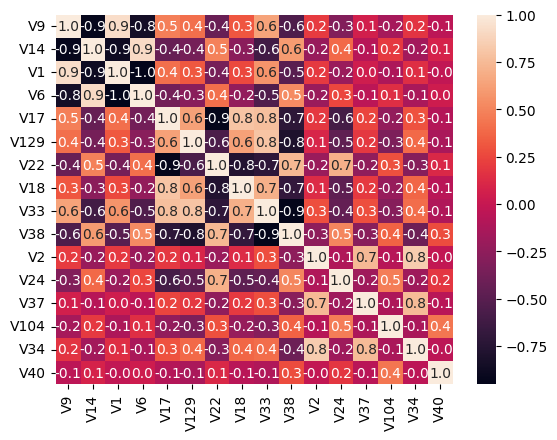

In [23]:
sns.heatmap(pd.DataFrame(x_anova).corr(), annot=True, fmt=".1f")
plt.show()